In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
data_variance = np.var(training_data.data / 255.0)
data_variance

0.06328692405746414

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [7]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        # print(encoding_indices.shape)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        # print(encodings.shape)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

In [8]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [11]:
batch_size = 256
num_training_updates = 50000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [12]:
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

In [13]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [14]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _,_ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [15]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [118]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [119]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.998
perplexity: 1.000

200 iterations
recon_error: 0.990
perplexity: 1.000

300 iterations
recon_error: 0.982
perplexity: 1.000

400 iterations
recon_error: 0.984
perplexity: 1.000

500 iterations
recon_error: 0.993
perplexity: 1.001

600 iterations
recon_error: 0.859
perplexity: 1.529

700 iterations
recon_error: 0.390
perplexity: 2.674

800 iterations
recon_error: 0.274
perplexity: 4.515

900 iterations
recon_error: 0.210
perplexity: 9.603

1000 iterations
recon_error: 0.176
perplexity: 15.631

1100 iterations
recon_error: 0.166
perplexity: 19.074

1200 iterations
recon_error: 0.159
perplexity: 22.168

1300 iterations
recon_error: 0.150
perplexity: 25.191

1400 iterations
recon_error: 0.138
perplexity: 31.663

1500 iterations
recon_error: 0.128
perplexity: 36.554

1600 iterations
recon_error: 0.121
perplexity: 39.212

1700 iterations
recon_error: 0.115
perplexity: 41.964

1800 iterations
recon_error: 0.112
perplexity: 44.522

1900 iterations
recon_error:

KeyboardInterrupt: ignored

In [120]:
torch.save(model.state_dict(), '/content/drive/MyDrive/VAE/VQVAE/vqvae_25000.pth')

In [16]:
model.load_state_dict(torch.load('/content/drive/MyDrive/VAE/VQVAE/vqvae_25000.pth'))

<All keys matched successfully>

## View Reconstructions

In [20]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [26]:
# print(valid_originals.shape, vq_output_eval.shape, valid_quantize.shape)
# sample = torch.randn(32,64,8,8).to(device)
# _, sample_valid_quantize, _, _, _ = model._vq_vae(sample)
# sample_valid_recon = model._decoder(sample_valid_quantize)
# sample.shape

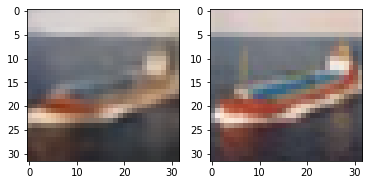

In [27]:
def viewsingle(recon, orig, i):
  img = orig.cpu().data+0.5
  rimg = recon.cpu().data+0.5
  npimg = img[i].numpy()
  rnpimg = rimg[i].numpy()

  npimg = np.transpose(npimg, (1,2,0))
  rnpimg = np.transpose(rnpimg, (1,2,0))
  return rnpimg,npimg 

recons, orig = viewsingle(valid_reconstructions,valid_originals,6)

plt.subplot(121), plt.imshow(recons)
plt.subplot(122), plt.imshow(orig)
plt.show()

In [23]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


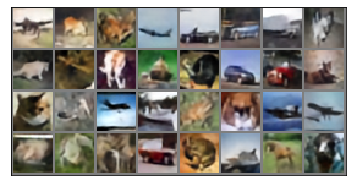

In [24]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

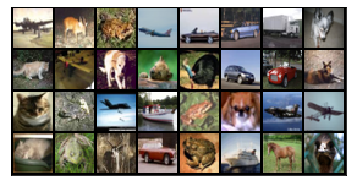

In [25]:
show(make_grid(valid_originals.cpu()+0.5))

Pixel CNN model as prior

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)



class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=10):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual

        self.class_cond_embedding = nn.Embedding(
            n_classes, 2 * dim
        )

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h

In [30]:
class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=10):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        # print(shp)
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        # print(x.shape)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, H)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(8, 8), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [31]:
n_embeddings=512
img_dim=8
n_layers=15
prior = GatedPixelCNN(n_embeddings, img_dim**2, n_layers).to(device)
criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(prior.parameters(), lr=3e-4)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [32]:
def train():
    train_loss = 0
    for batch_idx, (x, label) in enumerate(training_loader):
        bs = x.size(0)
        vq_output_eval = model._pre_vq_conv(model._encoder(x.to(device)))
        _, _, _, _, x = model._vq_vae(vq_output_eval)
        # print(x.shape)
        x = (x[:, 0]).long()
        
        x = x.view(bs,8,8)
        # print('x', x.shape)
        label = label.to(device)
           
        # Train PixelCNN with images
        logits = prior(x, label)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        loss = criterion(
            logits.view(-1, n_embeddings),
            x.view(-1)
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()
    
    return train_loss/len(training_loader)

def test():
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (x, label) in enumerate(validation_loader):
            bs = x.size(0)
            vq_output_eval = model._pre_vq_conv(model._encoder(x.to(device)))
            _, _, _, _, x = model._vq_vae(vq_output_eval)

            x = (x[:, 0]).long()
            x = x.view(bs, 8,8)
            label = label.to(device)

            logits = prior(x, label)
            
            
            logits = logits.permute(0, 2, 3, 1).contiguous()
            loss = criterion(
                logits.view(-1, n_embeddings),
                x.view(-1)
            )
            
            val_loss += (loss.item())

    return val_loss/len(validation_loader)

In [24]:
epochs=15
for epoch in range(epochs):
  train_loss = train()
  val_loss = test()
  print('epoch: {}/{}, Train loss: {:.6f}, Validation loss: {:.6f}'.format(epoch+1, epochs, train_loss, val_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 1/15, Train loss: 4.595406, Validation loss: 4.807550
epoch: 2/15, Train loss: 4.590656, Validation loss: 4.806686
epoch: 3/15, Train loss: 4.587456, Validation loss: 4.805642
epoch: 4/15, Train loss: 4.583102, Validation loss: 4.806218
epoch: 5/15, Train loss: 4.579499, Validation loss: 4.809597
epoch: 6/15, Train loss: 4.576014, Validation loss: 4.808617
epoch: 7/15, Train loss: 4.572375, Validation loss: 4.811542
epoch: 8/15, Train loss: 4.569864, Validation loss: 4.810915
epoch: 9/15, Train loss: 4.566445, Validation loss: 4.811773
epoch: 10/15, Train loss: 4.563341, Validation loss: 4.811467
epoch: 11/15, Train loss: 4.559847, Validation loss: 4.810062
epoch: 12/15, Train loss: 4.556728, Validation loss: 4.812263
epoch: 13/15, Train loss: 4.553143, Validation loss: 4.812245
epoch: 14/15, Train loss: 4.549586, Validation loss: 4.814261
epoch: 15/15, Train loss: 4.547214, Validation loss: 4.816528


In [27]:
torch.save(prior.state_dict(), '/content/drive/MyDrive/VAE/VQVAE/vqvae_pixelcnn_prior_65.pth')

In [33]:
prior.load_state_dict(torch.load('/content/drive/MyDrive/VAE/VQVAE/vqvae_pixelcnn_prior_65.pth'))

<All keys matched successfully>

In [67]:
def generate_samples():
    label = torch.arange(10).expand(4, 10).contiguous().view(-1)
    label = label.long().cuda()
    bs = 40
    num_embeddings=512
    shape=(8,8)
    x_q = prior.generate(label, shape=(8,8), batch_size=bs)
    x_q = x_q.view(-1,1)
    encodings = torch.zeros(x_q.shape[0], num_embeddings, device=x_q.device)
    encodings.scatter_(1, x_q, 1)

    embed_weight = model._vq_vae._embedding.weight
    quantized = torch.matmul(encodings, embed_weight).view(bs,*shape,-1)
    quantized = quantized.permute(0,3,1,2).contiguous()

    x_recon = model._decoder(quantized)


    # print(x_tilde[0])
    return x_recon, label

out, label = generate_samples()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [68]:
label_dic = {0:'Aeroplane', 1:'Automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


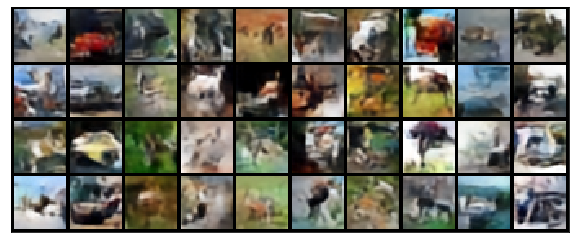

In [69]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

show(make_grid(out.detach().cpu()+0.5,nrow=10))